# Student Loan: Hyperparameter Tuning

The *hyperparameters* of a machine learning algorithm control its *flexibility*.  Greater flexibility can be desirable because it allows the model to react to nuances of the data.  However, too much model flexibility can also lead to overfitting.  Therefore, it is sometimes preferable to restrict the flexibility of a model to reduce overfitting.  

The trade-off between allowing for flexibility while at the same avoiding overfitting is referred to as the variance-bias tradeoff.

## Loading Packages

Let's begin by loading the packages that we will need.

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import time
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

## Reading-In Data

Next, let's read-in our data set.

In [ ]:
df_train = pd.read_csv('../data/student_loan.csv')
df_train

load_id deal_name  loan_age  cosign  income_annual        upb   
0         765579    2014_b        56       0      113401.60   36011.11  \
1         765580    2014_b        56       1      100742.34  101683.38   
2         765581    2014_b        56       0       46000.24   49249.37   
3         765582    2014_b        56       0      428958.96   36554.85   
4         765583    2014_b        56       0      491649.96    7022.30   
...          ...       ...       ...     ...            ...        ...   
1043306  1808885    2019_c         2       0      152885.00  115363.12   
1043307  1808886    2019_c         2       0      116480.00   77500.70   
1043308  1808887    2019_c         2       0       96800.00   16156.76   
1043309  1808888    2019_c         2       0       78400.14   77197.03   
1043310  1808889    2019_c        65       0       50447.28   65667.85   

         monthly_payment  fico  origbalance  mos_to_repay  repay_status   
0                 397.91   814     51453.60             0             0  \
1                1172.10   711    130271.33             0             0   
2                 593.57   772     62918.96             0             0   
3                 404.63   849     48238.73             0             0   
4                1967.46   815    106124.68             0             0   
...                  ...   ...          ...           ...           ...   
1043306          1212.22   798    116834.64             0             0   
1043307           831.13   826     79566.03             0             0   
1043308           232.34   781     16472.50             0             0   
1043309           833.57   777     78135.54             0             0   
1043310           767.10   765     82602.38             0             0   

         mos_to_balln  paid_label  
0                 124           0  
1                 124           0  
2                 124           0  
3                 125           0  
4                   4           0  
...               ...         ...  
1043306           118           0  
1043307           118           0  
1043308            82           0  
1043309           118           0  
1043310           119           0  

[1043311 rows x 13 columns]

We can inspect the columns of our data set with the `DataFrame.info()` method.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043311 entries, 0 to 1043310
Data columns (total 13 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   load_id          1043311 non-null  int64  
 1   deal_name        1043311 non-null  object 
 2   loan_age         1043311 non-null  int64  
 3   cosign           1043311 non-null  int64  
 4   income_annual    1043311 non-null  float64
 5   upb              1043311 non-null  float64
 6   monthly_payment  1043311 non-null  float64
 7   fico             1043311 non-null  int64  
 8   origbalance      1043311 non-null  float64
 9   mos_to_repay     1043311 non-null  int64  
 10  repay_status     1043311 non-null  int64  
 11  mos_to_balln     1043311 non-null  int64  
 12  paid_label       1043311 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 103.5+ MB


## Organizing Our Features and Labels

Now that we have our data in memory, we can separate the features and labels in preparation for model fitting.  We begin with the features.

In [ ]:
lst_features = \
    ['loan_age','cosign','income_annual', 'upb',              
    'monthly_payment','fico','origbalance',
    'mos_to_repay','repay_status','mos_to_balln',]    
df_X = df_train[lst_features]
df_y = df_train['paid_label']

And next we do the same for the labels.  Note that in our encoding a `1` stands for prepayment, while a `0` stands for non-prepayment.

In [ ]:
df_y = df_train['paid_label']
df_y

0          0
1          0
2          0
3          0
4          0
          ..
1043306    0
1043307    0
1043308    0
1043309    0
1043310    0
Name: paid_label, Length: 1043311, dtype: int64

## `sklearn.model_selection.KFold`

Cross-validation techniques are a useful for estimating out-of-sample goodness of fit metrics for a model.  Writing cross-validation code from scratch would involve a lot of boiler plate code, which basically amounts to lots of for-loops whose implementation yields very little insight.  

One of great things about `sklearn` is that it contains a variety of convenience functions that take care a lot of this sort boiler-plate code for you.

A great example of such a convenience function is `KFold()` which produces arrays of indexes that define a K-Fold cross validation.

The following code returns an object that when applied to a data set will yield the indexes for the training set and test set for each iteration of a 2-fold cross validation.

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 2, shuffle = True, random_state = 0)

We can use a for-loop to inspect these indexes:

In [ ]:
for train_index, test_index in kf.split(df_X, df_y):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [      1       2       3 ... 1043303 1043307 1043309] TEST: [      0       5       6 ... 1043306 1043308 1043310]
TRAIN: [      0       5       6 ... 1043306 1043308 1043310] TEST: [      1       2       3 ... 1043303 1043307 1043309]


---

**Research Challenge:** Google `sklearn.model_selection.StratifiedKFold` and describe the difference between it and `KFold()`.

In [ ]:
#| code-fold: true
#| code-summary: "Solution"
# The folds are made by preserving the percentage of samples for each class.

---

## Choosing Optimal `max_depth` for `DecisionTreeClassifier`

Recall that the decision tree algorithm is a process that iteratively partitions the feature space.  Specifically, for each iteration of the algorithm, a split is made along one particular dimension of the feature space.  The process is repeated until some kind of stopping criteria is met.  

The hyperparameters of a decision tree model control various criteria for stopping this iterative splitting process.  The more strict the stopping criteria (i.e. stopping faster) the less flexible the model.  The more lenient the stopping criteria (i.e. stopping slower) the more flexible the model.

Restricting the flexibility of a model by changing hyperparameters is also referred to as regularization.

In this section we demonstrate choosing an optimal `max_depth` value for a decision tree classifier on our student loan data.  Towards this end we will use cross-validation.

Let's import the functions that we will need.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

We will use 10-fold cross-validation, so let's invoke the required indexes with `KFold`.

In [ ]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

The following code calculates a 10-fold CV F1-score, expected-balance ratio, and average fit-time for various levels of `max_depth`.

In [ ]:
# various levels of max_depth we will try
lst_depth = [1, 2, 3, 4, 5, 10, 15, 20, 25]

# lists for storing average statistics 
lst_f1_avg = []
lst_eb_ratio_avg = []
lst_fit_time_avg = []
for ix_depth in lst_depth:

    # list for storing statitics for each fold of cross-validation
    lst_f1 = []
    lst_eb_ratio = []
    lst_fit_time = []
    for train_index, test_index in kf.split(df_X, df_y):    
        # creating training set 
        X_train = df_X.iloc[train_index]
        y_train = df_y.iloc[train_index]

        # creating test set
        X_test = df_X.iloc[test_index]
        y_test = df_y.iloc[test_index]

        # intantiating model
        mdl = DecisionTreeClassifier(max_depth = ix_depth, random_state = 0)

        # fit the model
        start = time.time()
        mdl.fit(X_train, y_train)
        arr_pred = mdl.predict(X_test)
        end = time.time()
        
        # fit time
        dbl_fit_time = end - start
        lst_fit_time.append(dbl_fit_time)

        # f1-score
        dbl_f1 = f1_score(y_test, arr_pred)
        lst_f1.append(dbl_f1) 

        # expected-balance ratio
        arr_pred_proba = mdl.predict_proba(X_test)[:,1]
        dbl_eb_ratio = (arr_pred_proba * X_test['upb']).sum() / (y_test * X_test['upb']).sum()
        lst_eb_ratio.append(dbl_eb_ratio)

    # calculating and storing average metrics
    fit_time_avg = np.round(np.mean(lst_fit_time), 1)
    lst_fit_time_avg.append(fit_time_avg)
    f1_avg = np.round(np.mean(lst_f1), 3)
    lst_f1_avg.append(f1_avg)
    eb_ratio_avg = np.round(np.mean(lst_eb_ratio), 3)
    lst_eb_ratio_avg.append(eb_ratio_avg)
    
    # printing some output so I know my code is running
    print(ix_depth)

1
2
3
4
5
10
15
20
25


Let's put our results into a `DataFrame`, and then graph them.

In [ ]:
df_results = pd.DataFrame({'max_depth':lst_depth, 'f1':lst_f1_avg, 'eb_ratio':lst_eb_ratio_avg, 'fit_time':lst_fit_time_avg})
df_results

max_depth     f1  eb_ratio  fit_time
0          1  0.374     1.261       0.7
1          2  0.464     1.128       1.1
2          3  0.444     1.048       1.8
3          4  0.459     1.054       2.3
4          5  0.470     0.984       2.9
5         10  0.486     1.043       5.8
6         15  0.478     1.016       8.4
7         20  0.463     0.997      10.5
8         25  0.441     0.978      12.2

### **Graph of F1**

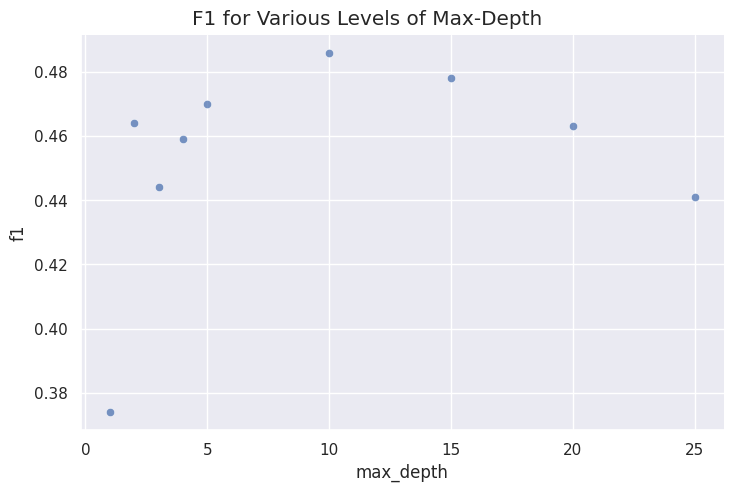

In [ ]:
%matplotlib inline
with sns.axes_style('darkgrid'):
    g = sns.relplot(
            x = 'max_depth',
            y = 'f1',
            data = df_results,
            alpha = 0.75,
            height = 5, 
            aspect = 1.5,
        );
    plt.subplots_adjust(top = 0.93);
    g.fig.suptitle('F1 for Various Levels of Max-Depth');

### **Graph of Expected-Balance Ratio**

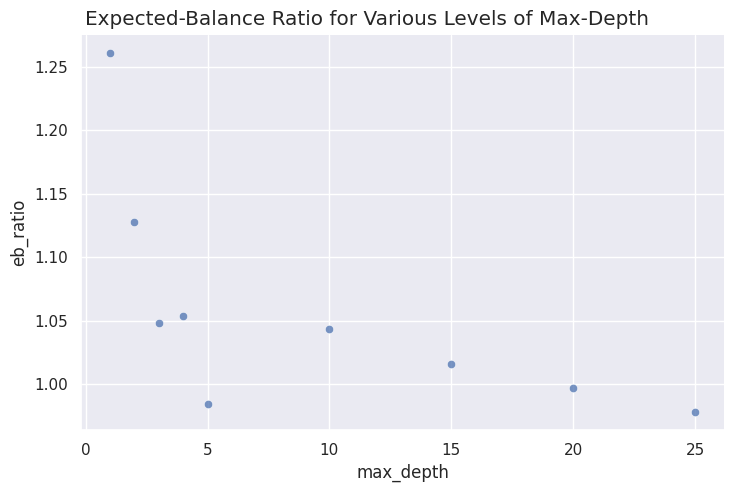

In [ ]:
with sns.axes_style('darkgrid'):
    g = sns.relplot(
            x = 'max_depth',
            y = 'eb_ratio',
            data = df_results,
            alpha = 0.75,
            height = 5, 
            aspect = 1.5,
        );
    plt.subplots_adjust(top = 0.93);
    g.fig.suptitle('Expected-Balance Ratio for Various Levels of Max-Depth');

### **Graph of Fit Time**

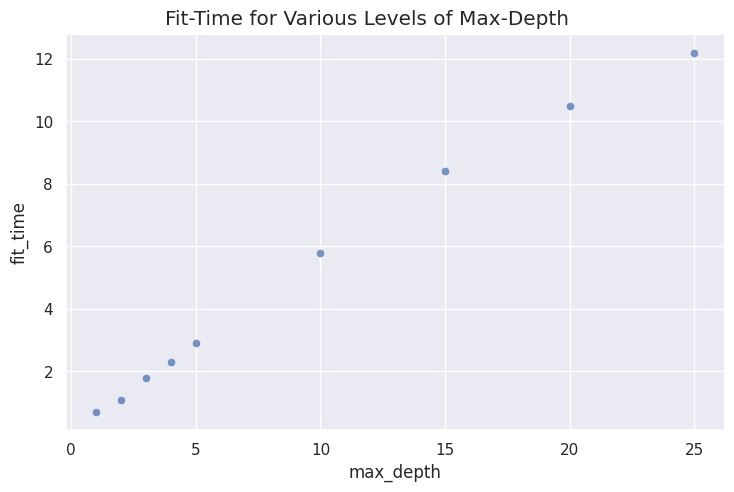

In [ ]:
with sns.axes_style('darkgrid'):
    g = sns.relplot(
            x = 'max_depth',
            y = 'fit_time',
            data = df_results,
            alpha = 0.75,
            height = 5, 
            aspect = 1.5,
        );
    plt.subplots_adjust(top = 0.93);
    g.fig.suptitle('Fit-Time for Various Levels of Max-Depth');

---

**Discussion Question:** Based on these results, which what would you choose for `max_depth`?

In [ ]:
#| code-fold: true
#| code-summary: "Solution"
# I would probaby choose something in the 5-10 range.

---